# **Research problem extraction**
This Colab notebook contains the implementation of solution to the task of `research problem extraction`.

## Problem statement
We need to build a **research problem extraction system** using the [training](https://github.com/ncg-task/training-data) and [test](https://github.com/ncg-task/test-data) dataset from NCG challenge. 
The image below shows how a part of the training dataset looks like.
For the task at hand, the relevant data is present in **research-problem.json**.

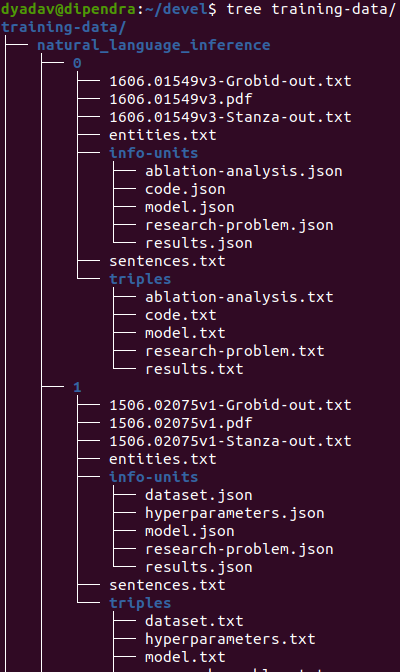

An example content of the `research-problem.json` file looks like the following:


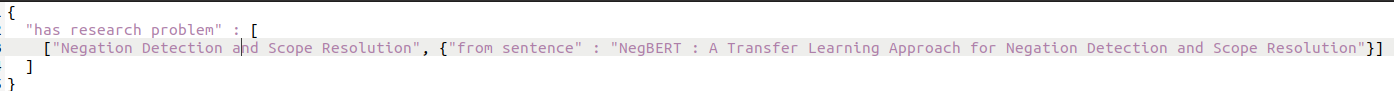

Now our task can be roughly divided into following steps:


1.   Extract the relevant test and train data from the dataset.
2.   Preprocess the extracted text data.
3.   Build a Model.
4.   Train the model.
5.   Evaluate the performance using F1, recall, precision score and additionally Jaccard similarity index.




In [ ]:
import csv
import os
import json
import pandas as pd
import re
import string
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import *
from tensorflow.keras.layers import *
import numpy as np
import tensorflow as tf
import random as rn
from keras.utils.vis_utils import plot_model
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau
from sklearn.metrics import classification_report


# 1. Get the datasets and extract the relevant data from it.
In this section, we clone the test and train dataset then we extract the research problems.



In [ ]:
cd /content/drive/MyDrive/ColabNotebooks/

/content/drive/MyDrive/ColabNotebooks


In [ ]:
!git clone https://github.com/ncg-task/training-data.git
!git clone https://github.com/ncg-task/test-data.git

In [ ]:
def save_csv(input_name,output_name):
  with open(output_name, mode='w', newline='') as rps:
    writer = csv.writer(rps)
    writer.writerow(["research_problems", "sentences"])
    writer.writerows(input_name)

In [ ]:
def save_data(root, output_file):
  research_problems_data = []
  for path, subdirs, files in os.walk(root):
      for name in files:
          path_add = name.split('/')
          if name == 'research-problem.json':
              file_address = os.path.join(path, name)
              with open(file_address, 'r') as json_file:
                  rp_data = json.load(json_file)["has research problem"]
                  for elements in rp_data:
                      rp_prob_sent = []
                      research_problems = []
                      if type(elements) is list:
                          for n in range(len(elements) - 1):
                              research_problems.append(elements[n])
                              from_sentence = elements[-1]["from sentence"]
                          if len(research_problems) > 1:
                              for rp in research_problems:
                                  if type(rp) is list:
                                      rp_prob_sent.append(rp[0])
                                  else:
                                      rp_prob_sent.append(rp)
                                  rp_prob_sent.append(from_sentence)
                                  research_problems_data.append(rp_prob_sent)
                                  rp_prob_sent = []
                          elif len(research_problems) == 1:
                              rp_prob_sent.append(research_problems[0])
                              rp_prob_sent.append(from_sentence)
                              research_problems_data.append(rp_prob_sent)
                              rp_prob_sent = []

                      elif type(elements) is str:
                          from_sentence = rp_data[-1]["from sentence"]
                          research_problems = rp_data[0]
                          rp_prob_sent.append(research_problems)
                          rp_prob_sent.append(from_sentence)
                          research_problems_data.append(rp_prob_sent)
                          rp_prob_sent = []
  save_csv(research_problems_data, output_file)

In [ ]:
save_data('/content/drive/MyDrive/ColabNotebooks/training-data', "train.csv")
save_data('/content/drive/MyDrive/ColabNotebooks/test-data',"test.csv")


In [ ]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

In [ ]:
train_data.head(10)

,research_problems,sentences
0,Text Comprehension,Gated - Attention Readers for Text Comprehension
1,machine reading,A recent trend to measure progress towards mac...
2,Large - scale Simple Question Answering,Large - scale Simple Question Answering with M...
3,large - scale question answering,Training large - scale question answering syst...
4,simple question answering,This paper studies the impact of multitask and...
5,Simple Question Answering,"However , while most recent efforts have focus..."
6,Task - Specific Tree Structures,Learning to Compose Task - Specific Tree Struc...
7,task - specific tree structures only from plai...,"In this paper , we propose Gumbel Tree - LSTM ..."
8,question answering,As an alternative to question answering method...
9,Question answering ( QA ),"Question answering ( QA ) , which returns exac..."


In [ ]:
print("shape of the training data : ", train_data.shape)
print("Number of data points in the train data : " , train_data.shape[0])
print("Number of feature in the train data : " , train_data.shape[1])

shape of the training data :  (635, 2)
Number of data points in the train data :  635
Number of feature in the train data :  2


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 635 entries, 0 to 634
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   research_problems  635 non-null    object
 1   sentences          635 non-null    object
dtypes: object(2)
memory usage: 10.0+ KB


In [ ]:
test_data.head(10)

,research_problems,sentences
0,Grammars,Recurrent Neural Network Grammars
1,Pretraining of Self - attention Networks,Cloze - driven Pretraining of Self - attention...
2,pretraining a bi-directional transformer model,We present a new approach for pretraining a bi...
3,Language model pretraining,Language model pretraining has recently been s...
4,Constituency Parsing,An Empirical Study of Building a Strong Baseli...
5,Syntactic constituency parsing,Syntactic constituency parsing is a fundamenta...
6,constituency parsing,Recent work has proposed several generative ne...
7,neural constituency parsing,Recent work on neural constituency parsing has...
8,Transition - based Constituent Parsing,In- Order Transition - based Constituent Parsing
9,neural transition - based constituent parsing,Both bottom - up and top - down strategies hav...


In [ ]:
print("shape of the test data : ", test_data.shape)
print("Number of data points in the test data : " , test_data.shape[0])
print("Number of feature in the test data : " , test_data.shape[1])

shape of the test data :  (330, 2)
Number of data points in the test data :  330
Number of feature in the test data :  2


In [ ]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330 entries, 0 to 329
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   research_problems  330 non-null    object
 1   sentences          330 non-null    object
dtypes: object(2)
memory usage: 5.3+ KB


# 2. Preprocess the dataset

In [ ]:
# data cleaning
# There were some word which i think might useful in the analysis which are present in the stopword are removed (like dont, would not ,does not , not etc ..)
stopwords= set([ 'im','the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about','between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', 'didn', 'doesn', 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', 'wasn', "wasn't", 'weren', "weren't", \
            'won', 'wouldn'])

def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub(r"(@[a-z]*)", "<mention>", text) #remove any word start with @
    text = re.sub(r"(&[a-z;]*)", "<none>", text) #remove any word start with &
    text = re.sub(r"(#[a-z;]*)", "<hash>", text) #remove any word start with #
    text = re.sub(r"(http|https|ftp|ftps)\:\/\/[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(\/\S*)?", "<link>", text)#remove LINKs
    text = re.sub(r'https?://\S+', '<link>', text) # remove https? links
    text = re.sub(r"(www.[a-z.\/0-9]*)", "<link>", text)#remove LINKs
    text = ' '.join(e.lower() for e in text.split() if e.lower() not in stopwords)
    return text

In [ ]:
# given each sentence it will call the clean_text()
train_data['sentences'] = train_data['sentences'].apply(lambda x:clean_text(x))
train_data['research_problems'] = train_data['research_problems'].apply(lambda x:clean_text(x))

test_data['sentences'] = test_data['sentences'].apply(lambda x:clean_text(x))
test_data['research_problems'] = test_data['research_problems'].apply(lambda x:clean_text(x))

In [ ]:
def word_len(text_data):
    # create a list to store the length of the sentence
    store = []
    # iterate thrrough each loop
    for i in text_data[:]:
        #split each word and count them and append in store
        store.append((len(str(i).split())))
    return store

In [ ]:
train_data['Number_of_word_in_sentences'] = word_len(train_data['sentences'])
train_data["Number_of_word_in_research problems"] = word_len(train_data['research_problems'])
train_data["difference_word_in_sentences_and_research_problems"] = train_data['Number_of_word_in_sentences'] - train_data["Number_of_word_in_research problems"]

test_data['Number_of_word_in_sentences'] = word_len(test_data['sentences'])
test_data["Number_of_word_in_research problems"] = word_len(test_data['research_problems'])
test_data["difference_word_in_sentences_and_research_problems"] = test_data['Number_of_word_in_sentences'] - test_data["Number_of_word_in_research problems"]

In [ ]:
train_data.head(10)

,research_problems,sentences,Number_of_word_in_sentences,Number_of_word_in_research problems,difference_word_in_sentences_and_research_problems
0,text comprehension,gated attention readers text comprehension,5,2,3
1,machine reading,recent trend measure progress towards machine ...,14,2,12
2,large scale simple question answering,large scale simple question answering memory n...,7,5,2
3,large scale question answering,training large scale question answering system...,17,4,13
4,simple question answering,paper studies impact multitask transfer learni...,26,3,23
5,simple question answering,however recent efforts focused designing syste...,32,3,29
6,task specific tree structures,learning compose task specific tree structures,6,4,2
7,task specific tree structures only plain text ...,paper propose gumbel tree lstm novel tree stru...,24,8,16
8,question answering,alternative question answering methods based f...,26,2,24
9,question answering qa,question answering qa returns exact answers ei...,26,3,23


In [ ]:
test_data.head(10)

,research_problems,sentences,Number_of_word_in_sentences,Number_of_word_in_research problems,difference_word_in_sentences_and_research_problems
0,grammars,recurrent neural network grammars,4,1,3
1,pretraining self attention networks,cloze driven pretraining self attention networks,6,4,2
2,pretraining bidirectional transformer model,present new approach pretraining bidirectional...,16,4,12
3,language model pretraining,language model pretraining recently shown prov...,14,3,11
4,constituency parsing,empirical study building strong baseline const...,7,2,5
5,syntactic constituency parsing,syntactic constituency parsing fundamental pro...,13,3,10
6,constituency parsing,recent work proposed several generative neural...,13,2,11
7,neural constituency parsing,recent work neural constituency parsing found ...,18,3,15
8,transition based constituent parsing,order transition based constituent parsing,5,4,1
9,neural transition based constituent parsing,bottom top strategies used neural transition b...,9,5,4


**Plotting based on word difference**


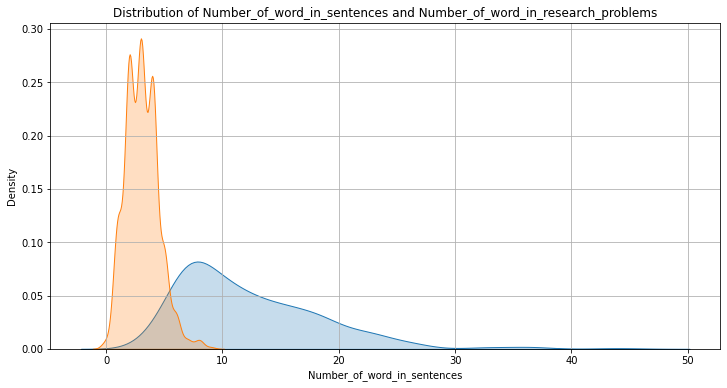

In [ ]:
# lets check out the distribution of Number_of_word_in_text and Number_of_word_in_select_text for train data
f, ax = plt.subplots(figsize=(12,6))
ax1 = sns.kdeplot(train_data['Number_of_word_in_sentences'], shade= True)
ax2 = sns.kdeplot(train_data["Number_of_word_in_research problems"],shade= True)
plt.title("Distribution of Number_of_word_in_sentences and Number_of_word_in_research_problems")
plt.grid()
plt.show()

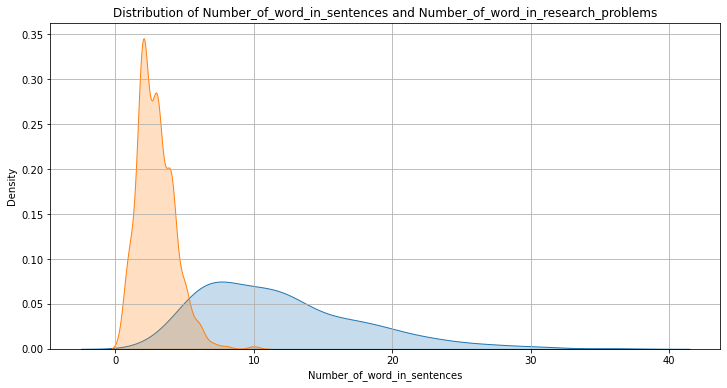

In [ ]:
# lets check out the distribution of Number_of_word_in_text and Number_of_word_in_select_text for test data
f, ax = plt.subplots(figsize=(12,6))
ax1 = sns.kdeplot(test_data['Number_of_word_in_sentences'], shade= True)
ax2 = sns.kdeplot(test_data["Number_of_word_in_research problems"],shade= True)
plt.title("Distribution of Number_of_word_in_sentences and Number_of_word_in_research_problems")
plt.grid()
plt.show()

Observation from distribution of both the train and test data:


*   We got two right skewed plot.
*   As we can see the length of sentences are in general more than research problems that is obvious as research problem is subset of the source sentence.
*   Similarly there are some over lap too.



In [ ]:
# splitting the training data into train and validation set
X_train , X_val , y_train , y_val = train_test_split(train_data , train_data.research_problems , test_size = .2,random_state=50)

In [ ]:
def Transfrom_text(textT,textS):
    """ this function will repalce to <tok> which are in both text and selected text"""
    t = " ".join("<tok>" for i in range (len(textS.split()))) # take each sentence in selected text find the length and put <tok>
    textT = textT.replace(textS,t) # replace those word wich are in both text and selected_text with <tok>
    return textT # return those sentence

def preprocess_text(df):
    df['sentences'] = df['sentences'].apply(lambda x: clean_text(x)) # create clean text column
    df['research_problems'] = df['research_problems'].apply(lambda x: clean_text(x)) # create clean selected text column
    df['target'] = pd.DataFrame([Transfrom_text(df['sentences'][i],df['research_problems'][i]) for i in range(len(df))]) # apply the transform function to all 3 column
    return df

In [ ]:
train_df = X_train.dropna()
train_df = train_df.reset_index()

val_df = X_val.dropna()
val_df = val_df.reset_index()

X_test = train_data.dropna()
X_test = train_data.reset_index(drop=True)

X_train = preprocess_text(train_df)
X_val = preprocess_text(val_df)
X_test = preprocess_text(X_test)

In [ ]:
X_train.head(5)

,index,research_problems,sentences,Number_of_word_in_sentences,Number_of_word_in_research problems,difference_word_in_sentences_and_research_problems,target
0,247,nli,nli central problem language understanding rec...,13,1,12,<tok> central problem language understanding r...
1,144,recurrent relational networks,recurrent relational networks,3,3,0,<tok> <tok> <tok>
2,257,machine reading comprehension mrc based qa,paper explore task machine reading comprehensi...,9,6,3,paper explore task <tok> <tok> <tok> <tok> <to...
3,151,paraphrase identification questions,present solution problem paraphrase identifica...,6,3,3,present solution problem <tok> <tok> <tok>
4,374,contextual sarcasm detection,cascade contextual sarcasm detection online di...,7,3,4,cascade <tok> <tok> <tok> online discussion fo...


In [ ]:
X_test.head(5)

,research_problems,sentences,Number_of_word_in_sentences,Number_of_word_in_research problems,difference_word_in_sentences_and_research_problems,target
0,text comprehension,gated attention readers text comprehension,5,2,3,gated attention readers <tok> <tok>
1,machine reading,recent trend measure progress towards machine ...,14,2,12,recent trend measure progress towards <tok> <t...
2,large scale simple question answering,large scale simple question answering memory n...,7,5,2,<tok> <tok> <tok> <tok> <tok> memory networks
3,large scale question answering,training large scale question answering system...,17,4,13,training <tok> <tok> <tok> <tok> systems compl...
4,simple question answering,paper studies impact multitask transfer learni...,26,3,23,paper studies impact multitask transfer learni...


In [ ]:
X_val.head(5)

,index,research_problems,sentences,Number_of_word_in_sentences,Number_of_word_in_research problems,difference_word_in_sentences_and_research_problems,target
0,203,directly reading documents,directly reading documents able answer questio...,8,3,5,<tok> <tok> <tok> able answer questions unsolv...
1,82,question answering qa,question answering qa popular topic natural la...,8,3,5,<tok> <tok> <tok> popular topic natural langua...
2,450,message level topic based sentiment analysis,datastories task deep lstm attention message l...,11,6,5,datastories task deep lstm attention <tok> <to...
3,609,neural abstractive summarization,therefore sequence sequence learning applied n...,13,3,10,therefore sequence sequence learning applied <...
4,571,temporal relation extraction,structured learning approach temporal relation...,6,3,3,structured learning approach <tok> <tok> <tok>


In [ ]:
##  below code snippet is for tokenization 

# now merge all words 
t2 = pd.DataFrame({'A': X_train.sentences})
t3 = pd.DataFrame({'A': X_train.target})
# print(t2)
all_tokens = pd.concat([t2,t3],axis = 0)

# create a tokenizer and fit all the words
token = Tokenizer(num_words=54000,filters='')
token.fit_on_texts(all_tokens.A) 
vocab_size = len(token.word_index)+1

MAX_LEN = 35
# give "<tok>" as 1
for word,i in token.word_index.items():
  if "<tok>" in word:
    token.word_index[word] = token.word_index["<tok>"]    
# it will create a vector based on the sentence word on train text data
train_seq_x = token.texts_to_sequences(X_train.sentences)
# pre padding
train_pad_seq_x = pad_sequences(train_seq_x,maxlen=MAX_LEN)
# create vector on train target data

# it will create a vector based on the sentence word on train text data
val_seq_x = token.texts_to_sequences(X_val.sentences)
# pre padding
val_pad_seq_x = pad_sequences(val_seq_x,maxlen=MAX_LEN )
# create vector on train target data

# it will create a vector based on the sentence word on test text data
test_seq_x = token.texts_to_sequences(X_test.sentences)
# pre padding
test_pad_seq_x = pad_sequences(test_seq_x,maxlen=MAX_LEN)

# create vector on train target data
train_seq_y = token.texts_to_sequences(X_train.target)
# # pre padding
train_pad_seq_y = pad_sequences(train_seq_y,maxlen=MAX_LEN)

# create vector on  target data
val_seq_y = token.texts_to_sequences(X_val.target)
# # pre padding
val_pad_seq_y = pad_sequences(val_seq_y,maxlen=MAX_LEN)

# create vector on  target data
test_seq_y = token.texts_to_sequences(X_test.target)
# # pre padding
test_pad_seq_y = pad_sequences(test_seq_y,maxlen=MAX_LEN)

# in the target data put 1 and 0 (if tok is present put 1 and all other values to 0)
train_pad_seq_y[train_pad_seq_y != token.word_index['<tok>']] = 0
train_pad_seq_y[train_pad_seq_y == token.word_index['<tok>']] = 1 

val_pad_seq_y[val_pad_seq_y != token.word_index['<tok>']] = 0
val_pad_seq_y[val_pad_seq_y == token.word_index['<tok>']] = 1

test_pad_seq_y[test_pad_seq_y != token.word_index['<tok>']] = 0
test_pad_seq_y[test_pad_seq_y == token.word_index['<tok>']] = 1

Word embedding with predefined glove

In [ ]:
!wget https://nlp.stanford.edu/data/glove.840B.300d.zip

In [ ]:
!unzip glove.840B.300d.zip && rm glove.840B.300d.zip

In [ ]:
## using predefined glove vector
def embedding_matrix_glove():
  # to track the progress of computing
  tqdm.pandas()
  # create a viable to store glove vector
  f = open('/content/drive/MyDrive/ColabNotebooks/glove.840B.300d.txt')
  # create a dictionary to 
  embedding_values = {}
  for line in tqdm(f):
    # take each word and the vector
    value = line.split(' ')
    # take the word
    word = value[0]
    # put all the numeric values to array
    coef = np.array(value[1:],dtype = 'float32')
    # take the word and array and put together
    embedding_values[word] = coef

  # take all the arrays from emmbeding values and stacked it
  all_embs = np.stack(embedding_values.values())
  # perform meand and standard deviation
  emb_mean,emb_std = all_embs.mean(), all_embs.std()
  #  create an embedding matrix of size (32515 ,300)
  embedding_matrix = np.random.normal(emb_mean, emb_std, (vocab_size, 300))

  lst = []
  # for each word and given count take the embedding values
  for word,i in tqdm(token.word_index.items()):
      # now take the word get a vector from embedding values(arrays)
      values = embedding_values.get(re.sub(r"[^A-Za-z]", "", word))
      if values is not None:
        embedding_matrix[i] = values
      else:
        lst.append(word) 

  return embedding_matrix 

In [ ]:
gv  = embedding_matrix_glove()

2196017it [02:15, 16170.37it/s]
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
100%|██████████| 1521/1521 [00:00<00:00, 121063.01it/s]


#3. Machine Learning Model

In [ ]:
# refer : https://udibhaskar.github.io/practical-ml/debugging%20nn/neural%20network/overfit/underfit/2020/02/03/Effective_Training_and_Debugging_of_a_Neural_Networks.html#Check-whether-forward-propagation-is-correct-or-not
loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=False, reduction=tf.keras.losses.Reduction. SUM_OVER_BATCH_SIZE)

##masked loss Eg for sequence output. 
def maskedLoss(train_pad_seq_y, y_pred):
    #getting mask value
    mask = tf.math.logical_not(tf.math.equal(train_pad_seq_y, 0))
    
    #calculating the loss
    loss_ = loss_function(train_pad_seq_y, y_pred)
    
    #converting mask dtype to loss_ dtype
    mask = tf.cast(mask, dtype=loss_.dtype)
    
    #applying the mask to loss
    loss_ = loss_*mask
    
    #getting mean over all the values
    loss_ = tf.reduce_sum(loss_)/tf.reduce_sum(mask)
    return loss_

In [ ]:
##Creating a BLSTM model

##fixing numpy RS
np.random.seed(42)

##fixing tensorflow RS
tf.random.set_seed(32)

##python RS
rn.seed(12)

HIDDEN_DIM= 256

inputs = Input(shape=(MAX_LEN, ), dtype='float32')

embedding_layer = Embedding(vocab_size,300,weights = [gv],trainable = False,name="Embedding_layer")
encoder_LSTM_1 = Bidirectional(LSTM(HIDDEN_DIM,return_sequences=True,kernel_regularizer=regularizers.l2(0.01),kernel_initializer=tf.keras.initializers.he_normal(seed=26),recurrent_initializer=tf.keras.initializers.orthogonal(seed=54)))
# when the output is a sequence we should use time distributed layer
# to understand more please go through this link : https://machinelearningmastery.com/timedistributed-layer-for-long-short-term-memory-networks-in-python/
dense_layer_relu = TimeDistributed(Dense(64, activation='relu',kernel_initializer=tf.keras.initializers.he_normal(seed=45)))
#dense_layer_relu_1 = TimeDistributed(Dense(64, activation='relu', kernel_initializer=tf.keras.initializers.he_normal(seed=45)))
dense_layer = TimeDistributed(Dense(1, activation='sigmoid', kernel_initializer=tf.keras.initializers.glorot_uniform(seed=45)))

encoder_embedding = embedding_layer(inputs)
Encoded_seq = encoder_LSTM_1(encoder_embedding)

outputs = dense_layer_relu(Encoded_seq)
outputs = dense_layer(outputs)

model = Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 35)]              0         
                                                                 
 Embedding_layer (Embedding)  (None, 35, 300)          456600    
                                                                 
 bidirectional (Bidirectiona  (None, 35, 512)          1140736   
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 35, 64)           32832     
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 35, 1)            65        
 tributed)                                                       
                                                             

In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam,loss = maskedLoss,metrics=['accuracy'])

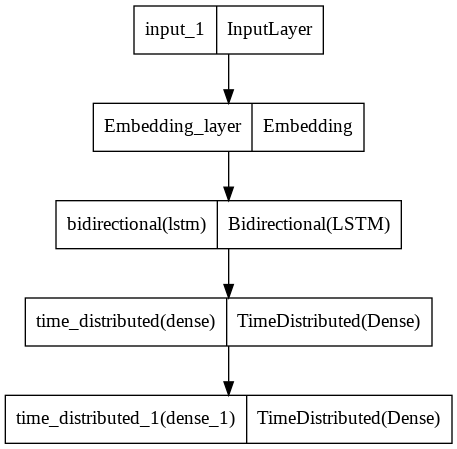

In [ ]:
plot_model(model)

In [ ]:
import datetime
# https://stackoverflow.com/questions/51889378/how-to-use-keras-reducelronplateau
def model_check_point_tensor_board():
  earlystopper = EarlyStopping(patience=8, verbose=1 ,restore_best_weights = True)
  checkpointer = ModelCheckpoint(filepath = 'model_1_1.h5',
                               verbose=1,
                               save_best_only=True, save_weights_only = True)

  reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.00001, verbose=1 , cooldown=1 )
  
  log_dir="logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True,write_grads=True)

  return [earlystopper , checkpointer , reduce_lr , tensorboard_callback]

# 4. Train the model

In [ ]:
history = model.fit(train_pad_seq_x,train_pad_seq_y,batch_size=64,epochs=70,validation_data=(val_pad_seq_x,val_pad_seq_y),callbacks = model_check_point_tensor_board(),verbose=0)



Epoch 1: val_loss improved from inf to 0.49048, saving model to model_1_1.h5

Epoch 2: val_loss improved from 0.49048 to 0.48588, saving model to model_1_1.h5

Epoch 3: val_loss improved from 0.48588 to 0.48418, saving model to model_1_1.h5

Epoch 4: val_loss did not improve from 0.48418

Epoch 5: val_loss improved from 0.48418 to 0.48246, saving model to model_1_1.h5

Epoch 6: val_loss did not improve from 0.48246

Epoch 7: val_loss did not improve from 0.48246

Epoch 7: ReduceLROnPlateau reducing learning rate to 1e-05.

Epoch 8: val_loss did not improve from 0.48246

Epoch 9: val_loss improved from 0.48246 to 0.48187, saving model to model_1_1.h5

Epoch 10: val_loss improved from 0.48187 to 0.48174, saving model to model_1_1.h5

Epoch 11: val_loss did not improve from 0.48174

Epoch 12: val_loss improved from 0.48174 to 0.48152, saving model to model_1_1.h5

Epoch 13: val_loss improved from 0.48152 to 0.48018, saving model to model_1_1.h5

Epoch 14: val_loss did not improve from 0.

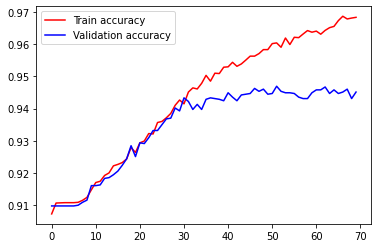

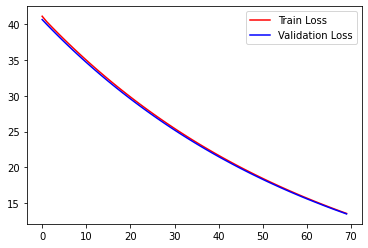

In [ ]:
plt.plot(history.history['accuracy'], 'r')
plt.plot(history.history['val_accuracy'], 'b')
plt.legend({'Train accuracy': 'r', 'Validation accuracy':'b'})
plt.show()

plt.plot(history.history['loss'], 'r')
plt.plot(history.history['val_loss'], 'b')
plt.legend({'Train Loss': 'r', 'Validation Loss':'b'})
plt.show()

# 4. Evaluation

In [ ]:
# This function decodes the encoded words
# takes a variable which will store all the index word
reverse_input_char_index = token.index_word
def decode_sequence(train_pad_seq_x,input_seq):
  # create a storage space to store string
  decoded_sentence = ""
  for i in range(len(input_seq)):
    # input seq basically it is the test data
    if (input_seq[i] == 1 or input_seq[i] == 2):
      if train_pad_seq_x[i] != 0:
        # take those sentences which are not cotaining zeros and put in token.index_word which will iteratively decode the words
        sampled_char = reverse_input_char_index[train_pad_seq_x[i]]
        decoded_sentence += sampled_char + " "   
  return decoded_sentence

In [ ]:
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    if (len(a)==0) & (len(b)==0): return 0.5
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [ ]:
def evaluate(pad_seq_x, pad_seq_y):
    # after fitting the model this function will be called , and it predict and rounded up
    pred = model.predict(pad_seq_x).round().astype(int)
    predicted = np.argmax(pred, axis=1)
    report = classification_report(np.argmax(pad_seq_y, axis=1), predicted, labels=np.unique(predicted))
    print(report)

    avg = 0
    for i in range(len(pad_seq_x)):  
        # now call the decode function , which will give some words and 
        st1 = decode_sequence(pad_seq_x[i],pred[i])
        st2 = decode_sequence(pad_seq_x[i],pad_seq_y[i])
        # call the jaccard function to meause the similarity
        avg += jaccard(st1,st2)
    print("Jaccard score = " , np.sum(avg) / len(pad_seq_x))

In [ ]:
evaluate(test_pad_seq_x, test_pad_seq_y)

              precision    recall  f1-score   support

           0       0.14      0.60      0.23         5
           1       1.00      0.50      0.67         2
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         1
           5       0.40      1.00      0.57         2
           6       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         1
          11       0.75      0.75      0.75         4
          12       0.67      0.40      0.50         5
          13       1.00      0.80      0.89         5
          14       0.56      0.83      0.67         6
          15       1.00      0.43      0.60         7
          16       0.62      1.00      0.77         5
          17       0.90      1.00      0.95         9
          18       0.80      0.80      0.80        10
          19       0.88      0.82      0.85        17
          20       0.79      0.86      0.83        22
          21       0.76    